In [ ]:
import numpy as np
import pandas as pd
import pickle

df = pd.read_pickle("data/usa_preimp.p")

In [76]:
import pycaret
pycaret.__version__

'3.3.2'

In [77]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 105075 entries, 0 to 105074
Data columns (total 40 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   year                  105075 non-null  int64  
 1   recipient_status      105075 non-null  int64  
 2   recipient_age         105075 non-null  int64  
 3   recipient_bmi         104814 non-null  float64
 4   recipient_height      105070 non-null  float64
 5   recipient_weight      105062 non-null  float64
 6   recipient_sex         105075 non-null  int64  
 7   recipient_race        105075 non-null  int64  
 8   recipient_blood_type  105075 non-null  int64  
 9   MELD                  105075 non-null  int64  
 10  recipient_albumin     105062 non-null  float64
 11  recipient_bili        105067 non-null  float64
 12  recipient_inr         105067 non-null  float64
 13  recipient_creatinine  105012 non-null  float64
 14  recipient_sodium      105067 non-null  float64
 15  

In [78]:
# # Step 1: Separate classes
# df_0 = df[df['graft_1yr'] == 0]
# df_1 = df[df['graft_1yr'] == 1]

# # Step 2: Calculate target number of 0s to match e.g. 72.8%
# target_total = int(len(df_1) / 0.272)
# target_zeros = int(target_total * 0.728)

# # Step 3: Randomly sample required number of 0s
# df_0_downsampled = df_0.sample(n=target_zeros, random_state=42)

# # Step 4: Concatenate and shuffle
# df_balanced = pd.concat([df_0_downsampled, df_1], axis=0).sample(frac=1, random_state=42).reset_index(drop=True)

# # Optional: Check new ratio
# print(df_balanced['graft_1yr'].value_counts(normalize=True))


In [79]:
sess_id = 123

target_value = 'graft_1yr'

In [80]:
args = {'data': df,
        'target': target_value,
        'session_id': sess_id,
        'train_size': 0.7,
        # 'test_data': df_usa,
        'preprocess': True,
        'imputation_type': 'iterative',
        'iterative_imputation_iters': 10,
        'numeric_iterative_imputer': 'br',
        'categorical_iterative_imputer': 'knn',
        
        # 'polynomial_features': True,
        # 'feature_selection': True,
        # 'n_features_to_select': 0.8,
        'ignore_features': ['recipient_days', 'graft_days', 'patient_1yr'],
        # 'keep_features': ['MELD', 'recipient_age', 'donor_age', 'recipient_bmi'],
        # 'remove_multicollinearity': False,
        # 'multicollinearity_threshold': 0.3,
        # 'pca': True,
        # 'pca_components': 10,
        'fold_strategy': 'stratifiedkfold',
        'fold': 5,
        # 'use_gpu': True,
        # 'fix_imbalance': True,
        # 'fix_imbalance_method': 'SMOTE',
        }

In [81]:
# import ClassificationExperiment and init the class
from pycaret.classification import *
s = setup(**args)
from pycaret.classification import ClassificationExperiment
exp = ClassificationExperiment()

,Description,Value
0,Session id,123
1,Target,graft_1yr
2,Target type,Binary
3,Original data shape,"(105075, 40)"
4,Transformed data shape,"(105075, 37)"
5,Transformed train set shape,"(73552, 37)"
6,Transformed test set shape,"(31523, 37)"
7,Ignore features,3
8,Numeric features,36
9,Rows with missing values,7.1%


In [82]:
# init setup on exp
exp.setup(**args)

,Description,Value
0,Session id,123
1,Target,graft_1yr
2,Target type,Binary
3,Original data shape,"(105075, 40)"
4,Transformed data shape,"(105075, 37)"
5,Transformed train set shape,"(73552, 37)"
6,Transformed test set shape,"(31523, 37)"
7,Ignore features,3
8,Numeric features,36
9,Rows with missing values,7.1%


In [83]:
include_models = [
    'lr', 'knn', 'dt', 'svm', 'rf', 'ada', 'gbc', 'et', 'mlp', 'lightgbm'
    ]

In [84]:
# compare baseline models
best = compare_models(
    errors = 'raise',
    sort = 'F1',
    include=include_models,
    )

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
dt,Decision Tree Classifier,0.8037,0.5197,0.1594,0.1361,0.1468,0.0367,0.0369,4.8660
mlp,MLP Classifier,0.7650,0.5930,0.1854,0.0797,0.0490,0.0066,0.0167,5.4620
svm,SVM - Linear Kernel,0.7403,0.5844,0.1959,0.0831,0.0399,0.0002,0.0026,5.2720
knn,K Neighbors Classifier,0.8872,0.5179,0.0124,0.1411,0.0229,0.0056,0.0109,6.9120
lightgbm,Light Gradient Boosting Machine,0.8938,0.6370,0.0042,0.4709,0.0084,0.0063,0.0351,5.5720
ada,Ada Boost Classifier,0.8938,0.6304,0.0014,0.3340,0.0028,0.0019,0.0155,5.0100
gbc,Gradient Boosting Classifier,0.8937,0.6420,0.0012,0.2415,0.0023,0.0013,0.0095,7.5220
et,Extra Trees Classifier,0.8940,0.6098,0.0003,0.4000,0.0005,0.0004,0.0082,4.7980
rf,Random Forest Classifier,0.8940,0.6105,0.0001,0.2000,0.0003,0.0002,0.0042,5.5580
lr,Logistic Regression,0.8939,0.6086,0.0000,0.0000,0.0000,-0.0002,-0.0026,5.4280


In [85]:
include_models = [
    'lr', 'knn', 'dt', 'svm', 'rf', 'ada', 'gbc', 'et', 'mlp', 'lightgbm'
    ]

In [86]:
# Results will be saved in this list
results = []

# Loop over estimators
for model_name in include_models:
    print(f"Running model: {model_name}")
    
    base_model = create_model(estimator=model_name)
    
    print()
    
    tuned_model = tune_model(
        base_model,
        optimize='F1',
        n_iter=10,
        # return_train_score=True,
        # choose_better=True
    )
    
    cv_results = pull()  # Pulls results from the last `tune_model` call
        
    # Extract tuned hyperparameters
    tuned_params = tuned_model.get_params()
    
    # Combine results into one row
    results.append({
        'Model': model_name,

        'Accuracy_Fold_0': cv_results['Accuracy'][0],
        'Accuracy_Fold_1': cv_results['Accuracy'][1],
        'Accuracy_Fold_2': cv_results['Accuracy'][2],
        'Accuracy_Fold_3': cv_results['Accuracy'][3],
        'Accuracy_Fold_4': cv_results['Accuracy'][4],
        'Accuracy_Mean': cv_results['Accuracy']['Mean'],
        'Accuracy_Std': cv_results['Accuracy']['Std'],

        'AUC_Fold_0': cv_results['AUC'][0],
        'AUC_Fold_1': cv_results['AUC'][1],
        'AUC_Fold_2': cv_results['AUC'][2],
        'AUC_Fold_3': cv_results['AUC'][3],
        'AUC_Fold_4': cv_results['AUC'][4],
        'AUC_Mean': cv_results['AUC']['Mean'],
        'AUC_Std': cv_results['AUC']['Std'],

        'Recall_Fold_0': cv_results['Recall'][0],
        'Recall_Fold_1': cv_results['Recall'][1],
        'Recall_Fold_2': cv_results['Recall'][2],
        'Recall_Fold_3': cv_results['Recall'][3],
        'Recall_Fold_4': cv_results['Recall'][4],
        'Recall_Mean': cv_results['Recall']['Mean'],
        'Recall_Std': cv_results['Recall']['Std'],

        'Prec_Fold_0': cv_results['Prec.'][0],
        'Prec_Fold_1': cv_results['Prec.'][1],
        'Prec_Fold_2': cv_results['Prec.'][2],
        'Prec_Fold_3': cv_results['Prec.'][3],
        'Prec_Fold_4': cv_results['Prec.'][4],
        'Prec_Mean': cv_results['Prec.']['Mean'],
        'Prec_Std': cv_results['Prec.']['Std'],

        'F1_Fold_0': cv_results['F1'][0],
        'F1_Fold_1': cv_results['F1'][1],
        'F1_Fold_2': cv_results['F1'][2],
        'F1_Fold_3': cv_results['F1'][3],
        'F1_Fold_4': cv_results['F1'][4],
        'F1_Mean': cv_results['F1']['Mean'],
        'F1_Std': cv_results['F1']['Std'],

        'Hyperparameters': tuned_params
    })
    print()
    print()

results_df = pd.DataFrame(results)
print(results_df)

Running model: lr


,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.8938,0.6005,0.0000,0.0000,0.0000,-0.0003,-0.0040
1,0.8938,0.6163,0.0000,0.0000,0.0000,-0.0004,-0.0049
2,0.8940,0.6039,0.0000,0.0000,0.0000,0.0000,0.0000
3,0.8940,0.6159,0.0000,0.0000,0.0000,0.0000,0.0000
4,0.8939,0.6063,0.0000,0.0000,0.0000,-0.0003,-0.0040
Mean,0.8939,0.6086,0.0000,0.0000,0.0000,-0.0002,-0.0026
Std,0.0001,0.0064,0.0000,0.0000,0.0000,0.0002,0.0021


,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.5920,0.6012,0.5449,0.1384,0.2207,0.0621,0.0889
1,0.5894,0.6171,0.5833,0.1444,0.2315,0.0741,0.1079
2,0.5906,0.6022,0.5439,0.1377,0.2197,0.0609,0.0874
3,0.6001,0.6146,0.5657,0.1449,0.2307,0.0745,0.1062
4,0.5965,0.6064,0.5484,0.1405,0.2236,0.0660,0.0941
Mean,0.5937,0.6083,0.5573,0.1412,0.2253,0.0675,0.0969
Std,0.0040,0.0065,0.0152,0.0030,0.0049,0.0058,0.0086


Fitting 5 folds for each of 10 candidates, totalling 50 fits


Running model: knn


,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.8872,0.5209,0.0103,0.1212,0.0189,0.0024,0.0047
1,0.8863,0.5164,0.0135,0.1355,0.0245,0.0054,0.0099
2,0.8888,0.5228,0.0167,0.2016,0.0308,0.0148,0.0292
3,0.8859,0.5181,0.0109,0.1111,0.0199,0.0009,0.0017
4,0.8878,0.5113,0.0109,0.1360,0.0202,0.0045,0.0090
Mean,0.8872,0.5179,0.0124,0.1411,0.0229,0.0056,0.0109
Std,0.0010,0.0040,0.0024,0.0316,0.0044,0.0049,0.0096


,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.8910,0.5183,0.0058,0.1475,0.0111,0.0031,0.0087
1,0.8909,0.5128,0.0051,0.1311,0.0099,0.0019,0.0053
2,0.8916,0.5224,0.0058,0.1698,0.0112,0.0042,0.0125
3,0.8899,0.5181,0.0038,0.0822,0.0074,-0.0021,-0.0055
4,0.8910,0.5167,0.0045,0.1186,0.0087,0.0009,0.0026
Mean,0.8909,0.5177,0.0050,0.1299,0.0096,0.0016,0.0047
Std,0.0006,0.0031,0.0007,0.0294,0.0015,0.0022,0.0061


Fitting 5 folds for each of 10 candidates, totalling 50 fits
Original model was better than the tuned model, hence it will be returned. NOTE: The display metrics are for the tuned model (not the original one).


Running model: dt


,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.8048,0.5233,0.1660,0.1415,0.1528,0.0433,0.0434
1,0.8006,0.5161,0.1551,0.1302,0.1416,0.0297,0.0299
2,0.8060,0.5172,0.1507,0.1331,0.1414,0.0325,0.0326
3,0.8033,0.5179,0.1559,0.1334,0.1438,0.0334,0.0335
4,0.8038,0.5242,0.1693,0.1423,0.1547,0.0446,0.0448
Mean,0.8037,0.5197,0.1594,0.1361,0.1468,0.0367,0.0369
Std,0.0018,0.0033,0.0070,0.0049,0.0057,0.0060,0.0061


,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.8793,0.5589,0.0353,0.1687,0.0583,0.0225,0.0306
1,0.8754,0.5425,0.0423,0.1630,0.0672,0.0245,0.0311
2,0.8794,0.5375,0.0231,0.1254,0.0390,0.0063,0.0089
3,0.8770,0.5283,0.0455,0.1807,0.0727,0.0314,0.0402
4,0.8771,0.5513,0.0359,0.1551,0.0583,0.0192,0.0253
Mean,0.8776,0.5437,0.0364,0.1586,0.0591,0.0208,0.0272
Std,0.0015,0.0106,0.0077,0.0185,0.0115,0.0083,0.0103


Fitting 5 folds for each of 10 candidates, totalling 50 fits
Original model was better than the tuned model, hence it will be returned. NOTE: The display metrics are for the tuned model (not the original one).


Running model: svm


,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.8940,0.5942,0.0000,0.0000,0.0000,0.0000,0.0000
1,0.8914,0.6127,0.0026,0.0870,0.0050,-0.0011,-0.0035
2,0.8937,0.5771,0.0013,0.2222,0.0026,0.0013,0.0093
3,0.1285,0.5455,0.9756,0.1063,0.1918,0.0008,0.0069
4,0.8940,0.5926,0.0000,0.0000,0.0000,0.0000,0.0000
Mean,0.7403,0.5844,0.1959,0.0831,0.0399,0.0002,0.0026
Std,0.3059,0.0225,0.3899,0.0821,0.0760,0.0008,0.0048


,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.8174,0.5484,0.1487,0.1459,0.1473,0.0451,0.0451
1,0.8224,0.5775,0.1660,0.1650,0.1655,0.0662,0.0662
2,0.8217,0.5628,0.1725,0.1679,0.1702,0.0703,0.0703
3,0.8215,0.5641,0.1597,0.1591,0.1594,0.0595,0.0595
4,0.8245,0.5672,0.1488,0.1560,0.1523,0.0545,0.0545
Mean,0.8215,0.5640,0.1592,0.1588,0.1589,0.0591,0.0591
Std,0.0023,0.0093,0.0094,0.0077,0.0084,0.0089,0.0089


Fitting 5 folds for each of 10 candidates, totalling 50 fits


Running model: rf


,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.8940,0.6035,0.0000,0.0000,0.0000,0.0000,0.0000
1,0.8940,0.6138,0.0000,0.0000,0.0000,0.0000,0.0000
2,0.8939,0.6066,0.0000,0.0000,0.0000,-0.0001,-0.0028
3,0.8940,0.6174,0.0000,0.0000,0.0000,0.0000,0.0000
4,0.8941,0.6112,0.0006,1.0000,0.0013,0.0011,0.0239
Mean,0.8940,0.6105,0.0001,0.2000,0.0003,0.0002,0.0042
Std,0.0001,0.0050,0.0003,0.4000,0.0005,0.0005,0.0099


,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.6384,0.6123,0.4981,0.1462,0.2261,0.0743,0.0981
1,0.6413,0.6350,0.5192,0.1518,0.2349,0.0847,0.1121
2,0.6453,0.6211,0.5324,0.1560,0.2413,0.0926,0.1224
3,0.6364,0.6325,0.5318,0.1522,0.2366,0.0860,0.1151
4,0.6332,0.6240,0.5221,0.1489,0.2318,0.0801,0.1073
Mean,0.6389,0.6250,0.5207,0.1510,0.2341,0.0835,0.1110
Std,0.0041,0.0082,0.0124,0.0033,0.0051,0.0061,0.0081


Fitting 5 folds for each of 10 candidates, totalling 50 fits


Running model: ada


,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.8938,0.6220,0.0013,0.2857,0.0026,0.0016,0.0127
1,0.8939,0.6387,0.0019,0.4286,0.0038,0.0029,0.0229
2,0.8939,0.6258,0.0013,0.3333,0.0026,0.0017,0.0149
3,0.8937,0.6344,0.0013,0.2222,0.0026,0.0013,0.0093
4,0.8939,0.6311,0.0013,0.4000,0.0026,0.0019,0.0176
Mean,0.8938,0.6304,0.0014,0.3340,0.0028,0.0019,0.0155
Std,0.0001,0.0059,0.0003,0.0750,0.0005,0.0005,0.0046


,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.8940,0.6153,0.0000,0.0000,0.0000,0.0000,0.0000
1,0.8940,0.6336,0.0000,0.0000,0.0000,0.0000,0.0000
2,0.8940,0.6246,0.0000,0.0000,0.0000,0.0000,0.0000
3,0.8940,0.6335,0.0000,0.0000,0.0000,0.0000,0.0000
4,0.8940,0.6244,0.0000,0.0000,0.0000,0.0000,0.0000
Mean,0.8940,0.6263,0.0000,0.0000,0.0000,0.0000,0.0000
Std,0.0000,0.0068,0.0000,0.0000,0.0000,0.0000,0.0000


Fitting 5 folds for each of 10 candidates, totalling 50 fits
Original model was better than the tuned model, hence it will be returned. NOTE: The display metrics are for the tuned model (not the original one).


Running model: gbc


,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.8935,0.6323,0.0006,0.1250,0.0013,0.0002,0.0014
1,0.8936,0.6490,0.0019,0.2727,0.0038,0.0023,0.0148
2,0.8937,0.6398,0.0006,0.1429,0.0013,0.0003,0.0026
3,0.8938,0.6509,0.0019,0.3333,0.0038,0.0026,0.0183
4,0.8939,0.6383,0.0006,0.3333,0.0013,0.0009,0.0105
Mean,0.8937,0.6420,0.0012,0.2415,0.0023,0.0013,0.0095
Std,0.0001,0.0069,0.0006,0.0907,0.0012,0.0010,0.0066


,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.8653,0.5654,0.0718,0.1734,0.1015,0.0420,0.0469
1,0.8619,0.5670,0.0981,0.1969,0.1309,0.0650,0.0697
2,0.8630,0.5530,0.0693,0.1605,0.0968,0.0351,0.0388
3,0.8626,0.5674,0.0815,0.1774,0.1116,0.0481,0.0525
4,0.8625,0.5490,0.0815,0.1771,0.1116,0.0480,0.0523
Mean,0.8631,0.5604,0.0804,0.1771,0.1105,0.0477,0.0520
Std,0.0012,0.0078,0.0101,0.0117,0.0117,0.0099,0.0101


Fitting 5 folds for each of 10 candidates, totalling 50 fits


Running model: et


,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.8940,0.6003,0.0006,1.0000,0.0013,0.0011,0.0239
1,0.8938,0.6142,0.0000,0.0000,0.0000,-0.0003,-0.0040
2,0.8941,0.6147,0.0006,1.0000,0.0013,0.0011,0.0239
3,0.8939,0.6139,0.0000,0.0000,0.0000,-0.0001,-0.0028
4,0.8940,0.6058,0.0000,0.0000,0.0000,0.0000,0.0000
Mean,0.8940,0.6098,0.0003,0.4000,0.0005,0.0004,0.0082
Std,0.0001,0.0057,0.0003,0.4899,0.0006,0.0006,0.0129


,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.6284,0.6116,0.5045,0.1436,0.2236,0.0701,0.0940
1,0.6450,0.6216,0.5103,0.1515,0.2336,0.0838,0.1100
2,0.6507,0.6252,0.5125,0.1543,0.2372,0.0888,0.1158
3,0.6382,0.6266,0.5202,0.1506,0.2336,0.0828,0.1102
4,0.6353,0.6197,0.5253,0.1504,0.2339,0.0828,0.1107
Mean,0.6395,0.6210,0.5146,0.1501,0.2324,0.0816,0.1081
Std,0.0077,0.0053,0.0074,0.0035,0.0046,0.0062,0.0074


Fitting 5 folds for each of 10 candidates, totalling 50 fits


Running model: mlp


,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.8924,0.5954,0.0026,0.1290,0.0050,0.0009,0.0034
1,0.2601,0.5720,0.9051,0.1162,0.2060,0.0222,0.0721
2,0.8936,0.5915,0.0000,0.0000,0.0000,-0.0008,-0.0070
3,0.8848,0.6062,0.0192,0.1531,0.0342,0.0108,0.0178
4,0.8939,0.6000,0.0000,0.0000,0.0000,-0.0001,-0.0028
Mean,0.7650,0.5930,0.1854,0.0797,0.0490,0.0066,0.0167
Std,0.2524,0.0116,0.3599,0.0661,0.0795,0.0089,0.0289


,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.8940,0.5855,0.0000,0.0000,0.0000,0.0000,0.0000
1,0.8940,0.5563,0.0000,0.0000,0.0000,0.0000,0.0000
2,0.8926,0.6044,0.0064,0.2439,0.0125,0.0071,0.0237
3,0.8940,0.5900,0.0000,0.0000,0.0000,0.0000,0.0000
4,0.8940,0.5903,0.0000,0.0000,0.0000,0.0000,0.0000
Mean,0.8937,0.5853,0.0013,0.0488,0.0025,0.0014,0.0047
Std,0.0006,0.0158,0.0026,0.0976,0.0050,0.0028,0.0095


Fitting 5 folds for each of 10 candidates, totalling 50 fits
Original model was better than the tuned model, hence it will be returned. NOTE: The display metrics are for the tuned model (not the original one).


Running model: lightgbm


,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.8940,0.6299,0.0058,0.5000,0.0114,0.0090,0.0448
1,0.8938,0.6408,0.0051,0.4211,0.0101,0.0076,0.0368
2,0.8944,0.6349,0.0038,0.8571,0.0077,0.0067,0.0532
3,0.8937,0.6483,0.0045,0.3889,0.0089,0.0065,0.0322
4,0.8933,0.6312,0.0019,0.1875,0.0038,0.0017,0.0087
Mean,0.8938,0.6370,0.0042,0.4709,0.0084,0.0063,0.0351
Std,0.0003,0.0068,0.0013,0.2189,0.0026,0.0025,0.0150


[LightGBM] [Info] Number of positive: 6238, number of negative: 52604
[LightGBM] [Info] Number of positive: 6237, number of negative: 52604
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.015692 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4563
[LightGBM] [Info] Number of positive: 6238, number of negative: 52604
[LightGBM] [Info] Number of data points in the train set: 58842, number of used features: 36
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.106013 -> initscore=-2.132133
[LightGBM] [Info] Start training from score -2.132133
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.006616 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4552
[LightGBM] [Info] Number of data points in 

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.8637,0.5910,0.0660,0.1582,0.0932,0.0328,0.0365
1,0.8628,0.5846,0.0622,0.1488,0.0877,0.0269,0.0299
2,0.8660,0.5901,0.0603,0.1567,0.0871,0.0299,0.0340
3,0.8705,0.5990,0.0661,0.1866,0.0976,0.0446,0.0517
4,0.8638,0.5913,0.0725,0.1684,0.1013,0.0401,0.0443
Mean,0.8654,0.5912,0.0654,0.1637,0.0934,0.0349,0.0393
Std,0.0028,0.0046,0.0042,0.0130,0.0055,0.0066,0.0078


Fitting 5 folds for each of 10 candidates, totalling 50 fits
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] bagging_fraction is set=0.5, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] bagging_fraction is set=0.6, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM

In [87]:
results_df.to_csv("results_usa/model_comparison_results.csv", index=False)
results_df.to_excel("results_usa/model_comparison_results.xlsx", index=False)

In [88]:
results_df_transposed = results_df.T.reset_index()
results_df_transposed.to_csv("results_usa/model_comparison_results_transposed.csv", index=False)
results_df_transposed.to_excel("results_usa/model_comparison_results_transposed.xlsx", index=False)

# Best Model

In [89]:
best_model = create_model(estimator = 'rf')

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.8940,0.6035,0.0000,0.0000,0.0000,0.0000,0.0000
1,0.8940,0.6138,0.0000,0.0000,0.0000,0.0000,0.0000
2,0.8939,0.6066,0.0000,0.0000,0.0000,-0.0001,-0.0028
3,0.8940,0.6174,0.0000,0.0000,0.0000,0.0000,0.0000
4,0.8941,0.6112,0.0006,1.0000,0.0013,0.0011,0.0239
Mean,0.8940,0.6105,0.0001,0.2000,0.0003,0.0002,0.0042
Std,0.0001,0.0050,0.0003,0.4000,0.0005,0.0005,0.0099


In [90]:
tuned_model = tune_model(
    best_model,
    n_iter=10,
    optimize = 'F1',
)

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.6384,0.6123,0.4981,0.1462,0.2261,0.0743,0.0981
1,0.6413,0.6350,0.5192,0.1518,0.2349,0.0847,0.1121
2,0.6453,0.6211,0.5324,0.1560,0.2413,0.0926,0.1224
3,0.6364,0.6325,0.5318,0.1522,0.2366,0.0860,0.1151
4,0.6332,0.6240,0.5221,0.1489,0.2318,0.0801,0.1073
Mean,0.6389,0.6250,0.5207,0.1510,0.2341,0.0835,0.1110
Std,0.0041,0.0082,0.0124,0.0033,0.0051,0.0061,0.0081


Fitting 5 folds for each of 10 candidates, totalling 50 fits


In [91]:
print(tuned_model)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                       class_weight='balanced_subsample', criterion='entropy',
                       max_depth=4, max_features='log2', max_leaf_nodes=None,
                       max_samples=None, min_impurity_decrease=0.0002,
                       min_samples_leaf=5, min_samples_split=9,
                       min_weight_fraction_leaf=0.0, monotonic_cst=None,
                       n_estimators=130, n_jobs=-1, oob_score=False,
                       random_state=123, verbose=0, warm_start=False)


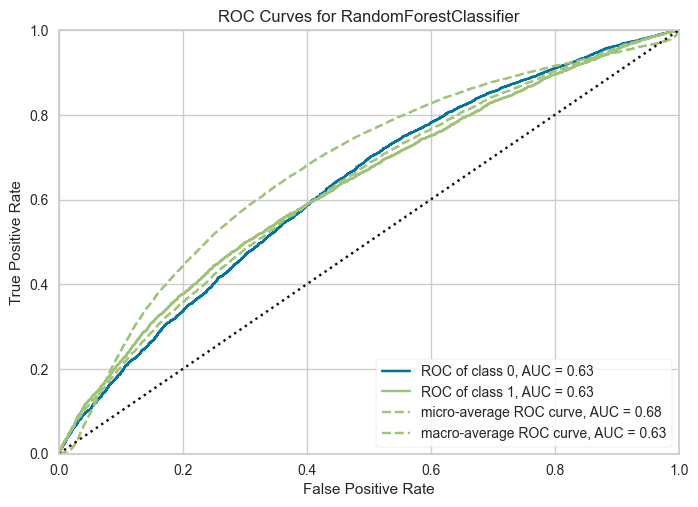

In [92]:
plot_model(tuned_model, plot = 'auc')

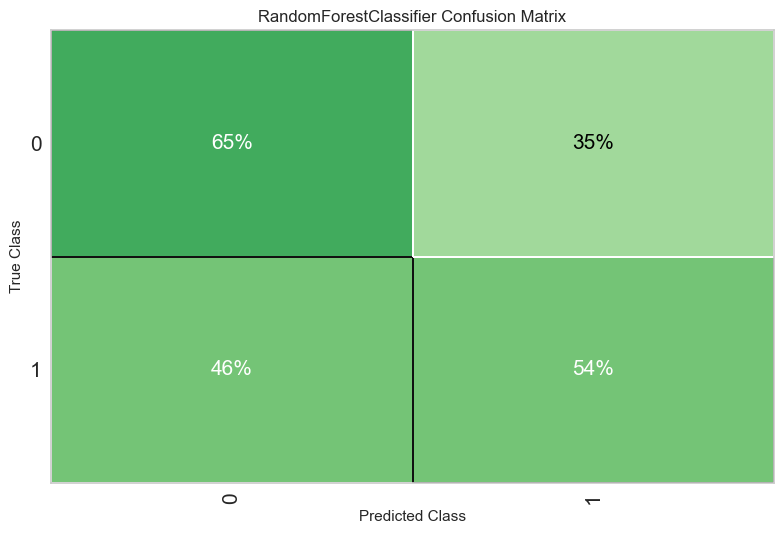

In [93]:
plot_model(tuned_model,
           plot = 'confusion_matrix',
           plot_kwargs = {'percent' : True}
           )

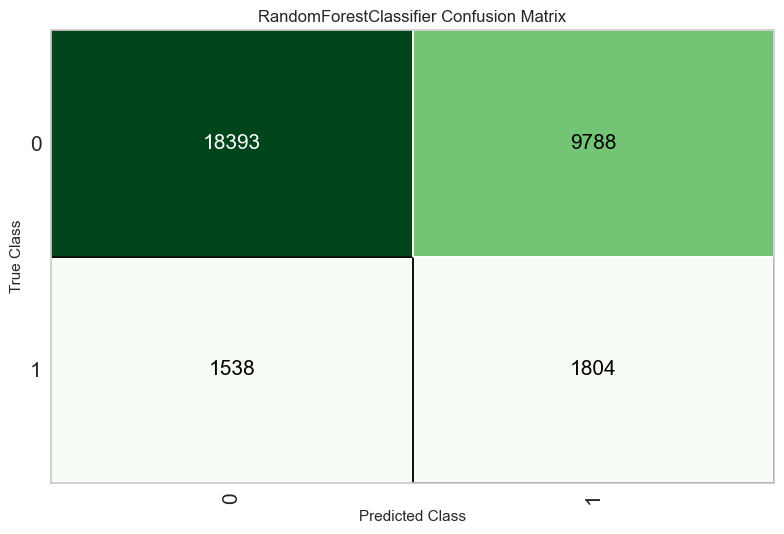

In [94]:
plot_model(tuned_model,
           plot = 'confusion_matrix',
           # plot_kwargs = {'percent' : True}
           )

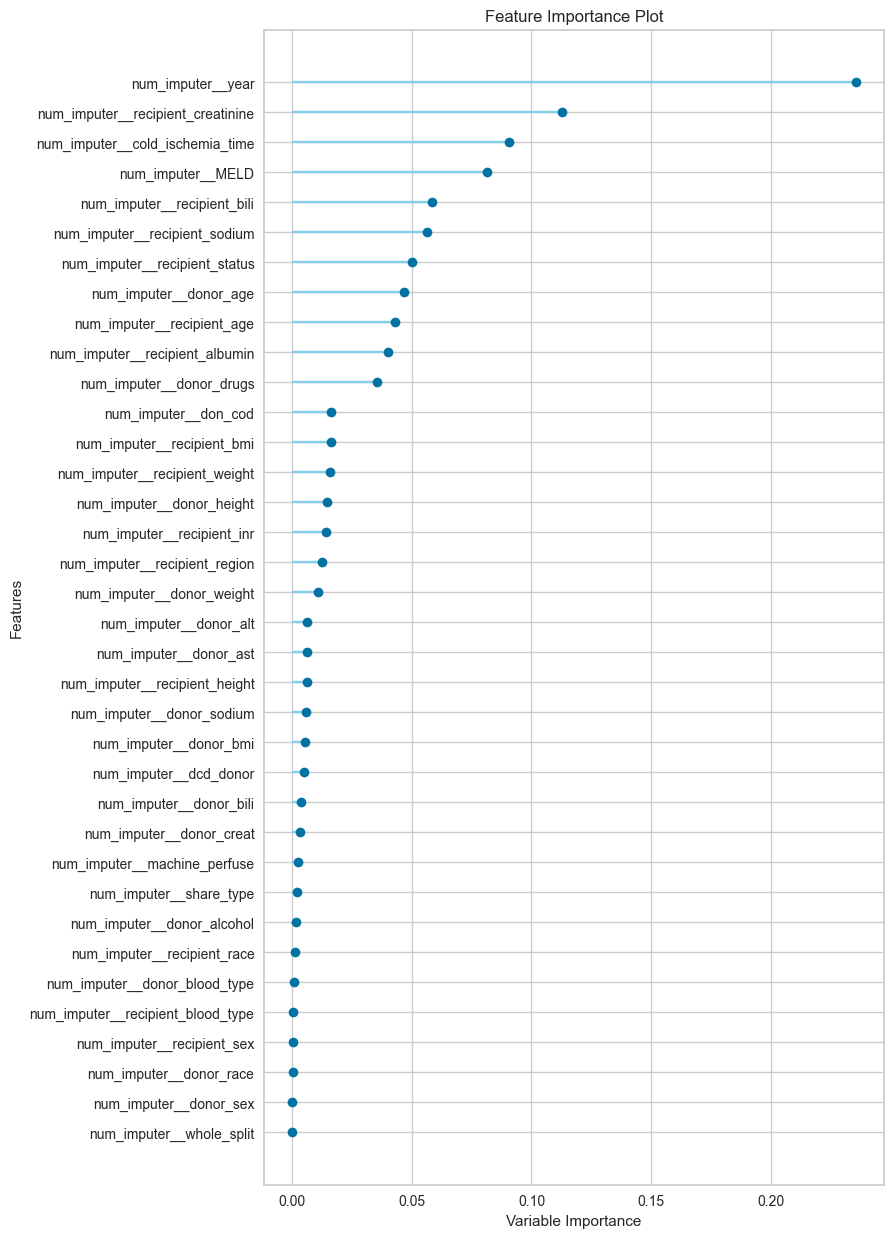

In [95]:
plot_model(tuned_model, plot = 'feature_all')

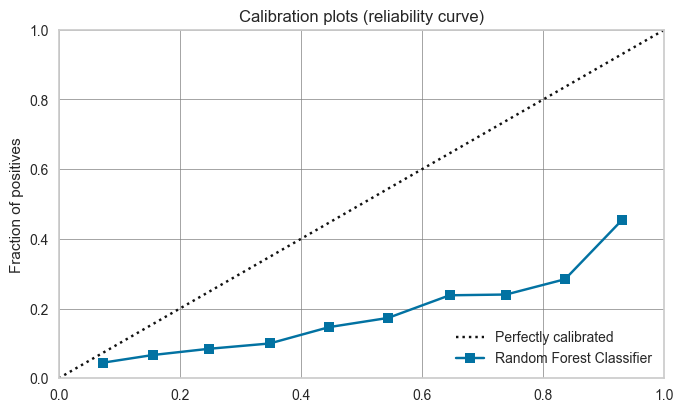

In [96]:
plot_model(tuned_model, plot = 'calibration')

In [97]:
import matplotlib.pyplot as plt
plt.figure().canvas.get_supported_filetypes()

{'eps': 'Encapsulated Postscript',
 'jpg': 'Joint Photographic Experts Group',
 'jpeg': 'Joint Photographic Experts Group',
 'pdf': 'Portable Document Format',
 'pgf': 'PGF code for LaTeX',
 'png': 'Portable Network Graphics',
 'ps': 'Postscript',
 'raw': 'Raw RGBA bitmap',
 'rgba': 'Raw RGBA bitmap',
 'svg': 'Scalable Vector Graphics',
 'svgz': 'Scalable Vector Graphics',
 'tif': 'Tagged Image File Format',
 'tiff': 'Tagged Image File Format',
 'webp': 'WebP Image Format'}

<Figure size 800x550 with 0 Axes>

<Axes: title={'center': 'ROC Curves for RandomForestClassifier'}, xlabel='False Positive Rate', ylabel='True Positive Rate'>

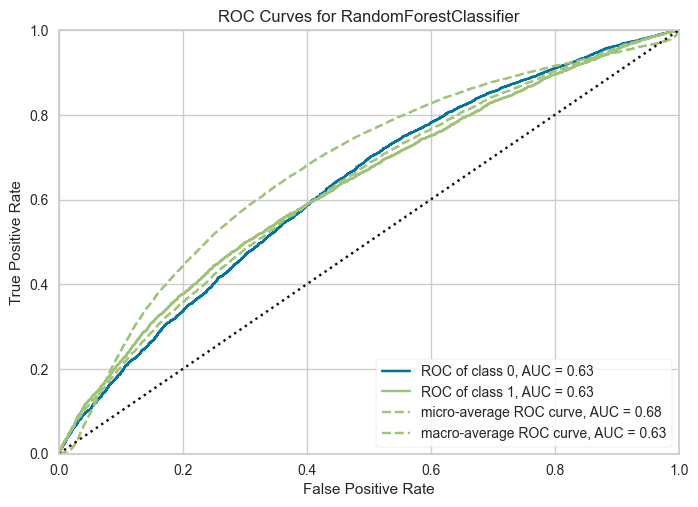

In [98]:
from yellowbrick.regressor import ResidualsPlot
from yellowbrick.classifier import ROCAUC

X_train, X_test, y_train, y_test = get_config('X_train'), get_config('X_test_transformed'), get_config('y_train'), get_config('y_test_transformed')

visualizer = ROCAUC(tuned_model)
visualizer.fit(X_train, y_train)
visualizer.score(X_test, y_test)
visualizer.poof(outpath="results_usa/auc.svg")

<Axes: title={'center': 'Precision-Recall Curve for RandomForestClassifier'}, xlabel='Recall', ylabel='Precision'>

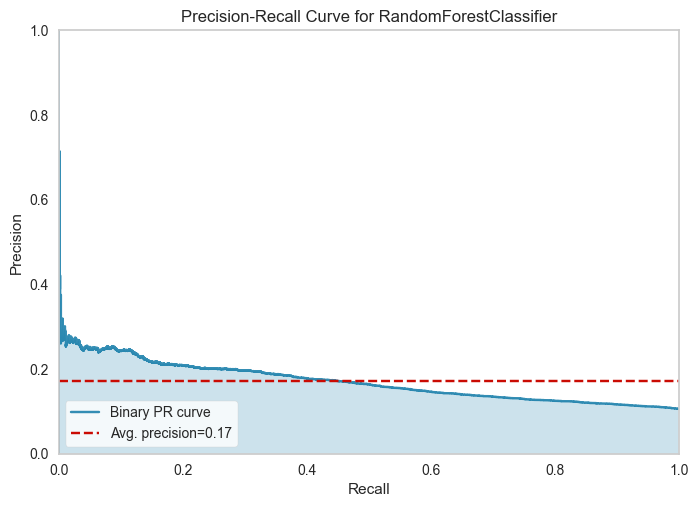

In [99]:
from yellowbrick.classifier import PrecisionRecallCurve
visualizer = PrecisionRecallCurve(tuned_model)
visualizer.fit(X_train, y_train)
visualizer.score(X_test, y_test)
visualizer.poof(outpath="results_usa/prc.svg")

In [ ]:
raise Exception("Stop")